In [57]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os
from eofs.xarray import Eof
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Input, Reshape, AveragePooling2D, MaxPooling2D, Conv2DTranspose, TimeDistributed, LSTM, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
import seaborn as sns

from scipy.stats import distributions

import random

from CNN_helper import get_nrmse_spatial, get_nrmse_global, get_nrmse, get_vpd, input_for_training, output_for_training, create_predictdand_data, normalize

def get_rmse(test_scenario, preds):
    hursTest = xr.open_dataset('vpd_data/hurs_' + test_scenario + '.nc')
    tasTest = xr.open_dataset('vpd_data/tas_' + test_scenario + '.nc')
    vpdTest = get_vpd(hursTest.hurs, tasTest.tas).to_dataset(name='vpd')
    Y_test = vpdTest.sel(time=slice('2024', None))
    vpd_truth = Y_test["vpd"]

    return [get_nrmse_spatial(vpd_truth, preds['vpd']), get_nrmse_global(vpd_truth, preds['vpd']), get_nrmse(vpd_truth, preds['vpd'])]
    

def train_CNN(scenarios):
    len_historical = 165
    slider = 10

    X_train = []
    Y_train = []
    data_path = 'train_val/'
    
    for i, simu in enumerate(scenarios):
    
        input_name = 'inputs_' + simu + '.nc'

        
        input_xr = xr.open_dataset(data_path + input_name)
        hursTrain = xr.open_dataset(f'vpd_data/hurs_{simu}.nc')
        tasTrain = xr.open_dataset(f'vpd_data/tas_{simu}.nc')
        output_xr = get_vpd(hursTrain.hurs, tasTrain.tas).to_dataset(name='vpd')
        
        print(input_xr.dims, simu)
        
        X_train.append(input_xr)
        Y_train.append(output_xr)

    # Compute mean/std of each variable for the whole dataset
    meanstd_inputs = {}
    
    for var in ['CO2', 'CH4', 'SO2', 'BC']:
        array = np.concatenate([X_train[i][var].data for i in [0, 1, 2]] + 
                               [X_train[i][var].sel(time=slice(len_historical, None)).data for i in range(1, 3)])
        print((array.mean(), array.std()))
        meanstd_inputs[var] = (array.mean(), array.std())

    # normalize input data 
    X_train_norm = [] 
    for i, train_xr in enumerate(X_train): 
        for var in ['CO2', 'CH4', 'SO2', 'BC']: 
            var_dims = train_xr[var].dims
            train_xr=train_xr.assign({var: (var_dims, normalize(train_xr[var].data, var, meanstd_inputs))}) 
        X_train_norm.append(train_xr)
    var_to_predict = 'vpd'
    X_train_all = np.concatenate([input_for_training(X_train_norm[i], slider=slider, len_historical=len_historical) for i in range(len(scenarios))], axis = 0)
    Y_train_all = np.concatenate([output_for_training(Y_train[i], var_to_predict, slider=slider, len_historical=len_historical) for i in range(len(scenarios))], axis=0)

    keras.backend.clear_session()
    cnn_model = None

    cnn_model = Sequential()
    cnn_model.add(Input(shape=(slider, 96, 144, 4)))
    cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu'), input_shape=(slider, 96, 144, 4)))
    cnn_model.add(TimeDistributed(AveragePooling2D(2)))
    cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
    cnn_model.add(LSTM(35, activation='relu'))
    cnn_model.add(Dense(1*96*144))
    cnn_model.add(Activation('linear'))
    cnn_model.add(Reshape((1, 96, 144)))

    cnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

    hist = cnn_model.fit(X_train_all,
                     Y_train_all,
                     use_multiprocessing=True, 
                     #workers=5,
                     batch_size=16,
                     epochs=30,
                     verbose=1)

    X_test = xr.open_dataset('train_val/inputs_ssp245.nc')

    for var in ['CO2', 'CH4', 'SO2', 'BC']:
        var_dims = X_test[var].dims
        X_test = X_test.assign({var: (var_dims, normalize(X_test[var].data, var, meanstd_inputs))}) 
        
    X_test_np = input_for_training(X_test, slider=slider, skip_historical=False, len_historical=len_historical)

    # Make predictions using trained model 
    predictions = cnn_model.predict(X_test_np)
    # reshape to xarray 
    predictions = predictions.reshape(predictions.shape[0], predictions.shape[2], predictions.shape[3])
    predictions = xr.DataArray(predictions, dims=['time', 'lat', 'lon'], coords=[X_test.time.data[slider-1:], X_test.latitude.data, X_test.longitude.data])
    predictions = predictions.transpose('time', 'lat', 'lon').sel(time=slice(2015, None)).to_dataset(name=var_to_predict)
    
    #predictions.to_netcdf('ssp245_predict_vpd.nc'.format(var_to_predict), 'w')

    return predictions


In [58]:
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']

In [59]:
predictions = train_CNN(scenarios)

FrozenMappingWarningOnValuesAccess({'time': 165, 'longitude': 144, 'latitude': 96}) historical
FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp126
FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp370
FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp585
(2268.557449006572, 1744.3475639403723)
(0.30820583411919633, 0.21020694107580368)
(2.936739507770543e-12, 2.2988632443266395e-11)
(2.1944110281131104e-13, 1.407829987477429e-12)
Epoch 1/30
25/25 [==============================] - 41s 2s/step - loss: 0.4353 - mse: 0.4353
Epoch 2/30
25/25 [==============================] - 40s 2s/step - loss: 0.2807 - mse: 0.2807
Epoch 3/30
25/25 [==============================] - 40s 2s/step - loss: 0.0526 - mse: 0.0526
Epoch 4/30
25/25 [==============================] - 37s 1s/step - loss: 0.0066 - mse: 0.0066
Epoch 5/30
25/25 [==============================] - 37s 1s/step - loss: 0.0044 - mse

In [91]:
hursTest = xr.open_dataset('vpd_data/hurs_ssp245.nc')
tasTest = xr.open_dataset('vpd_data/tas_ssp245.nc')
vpdTest = get_vpd(hursTest.hurs, tasTest.tas).to_dataset(name='vpd')

In [92]:
Y_test = vpdTest.sel(time=slice(2024, None))
vpd_truth = Y_test['vpd']

In [65]:
nrmses = [[
        get_nrmse_spatial(vpd_truth, predictions['vpd']), 
        get_nrmse_global(vpd_truth, predictions['vpd']),
        get_nrmse(vpd_truth, predictions['vpd'])
]]

nrmse_table = pd.DataFrame(data=nrmses, index=['vpd'], columns=['spatial', 'global', 'total']).round(3)
nrmse_table

,spatial,global,total
vpd,0.058,0.019,0.154


In [68]:
# variables used in plotting
p_level = 0.05
proj = ccrs.PlateCarree()
kwargs = [dict(vmin=-4, vmax=4), dict(vmin=-4, vmax=4), dict(vmin=-0.2, vmax=0.2)]
titles = ['Predicted', 'True', 'Differences']

In [69]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

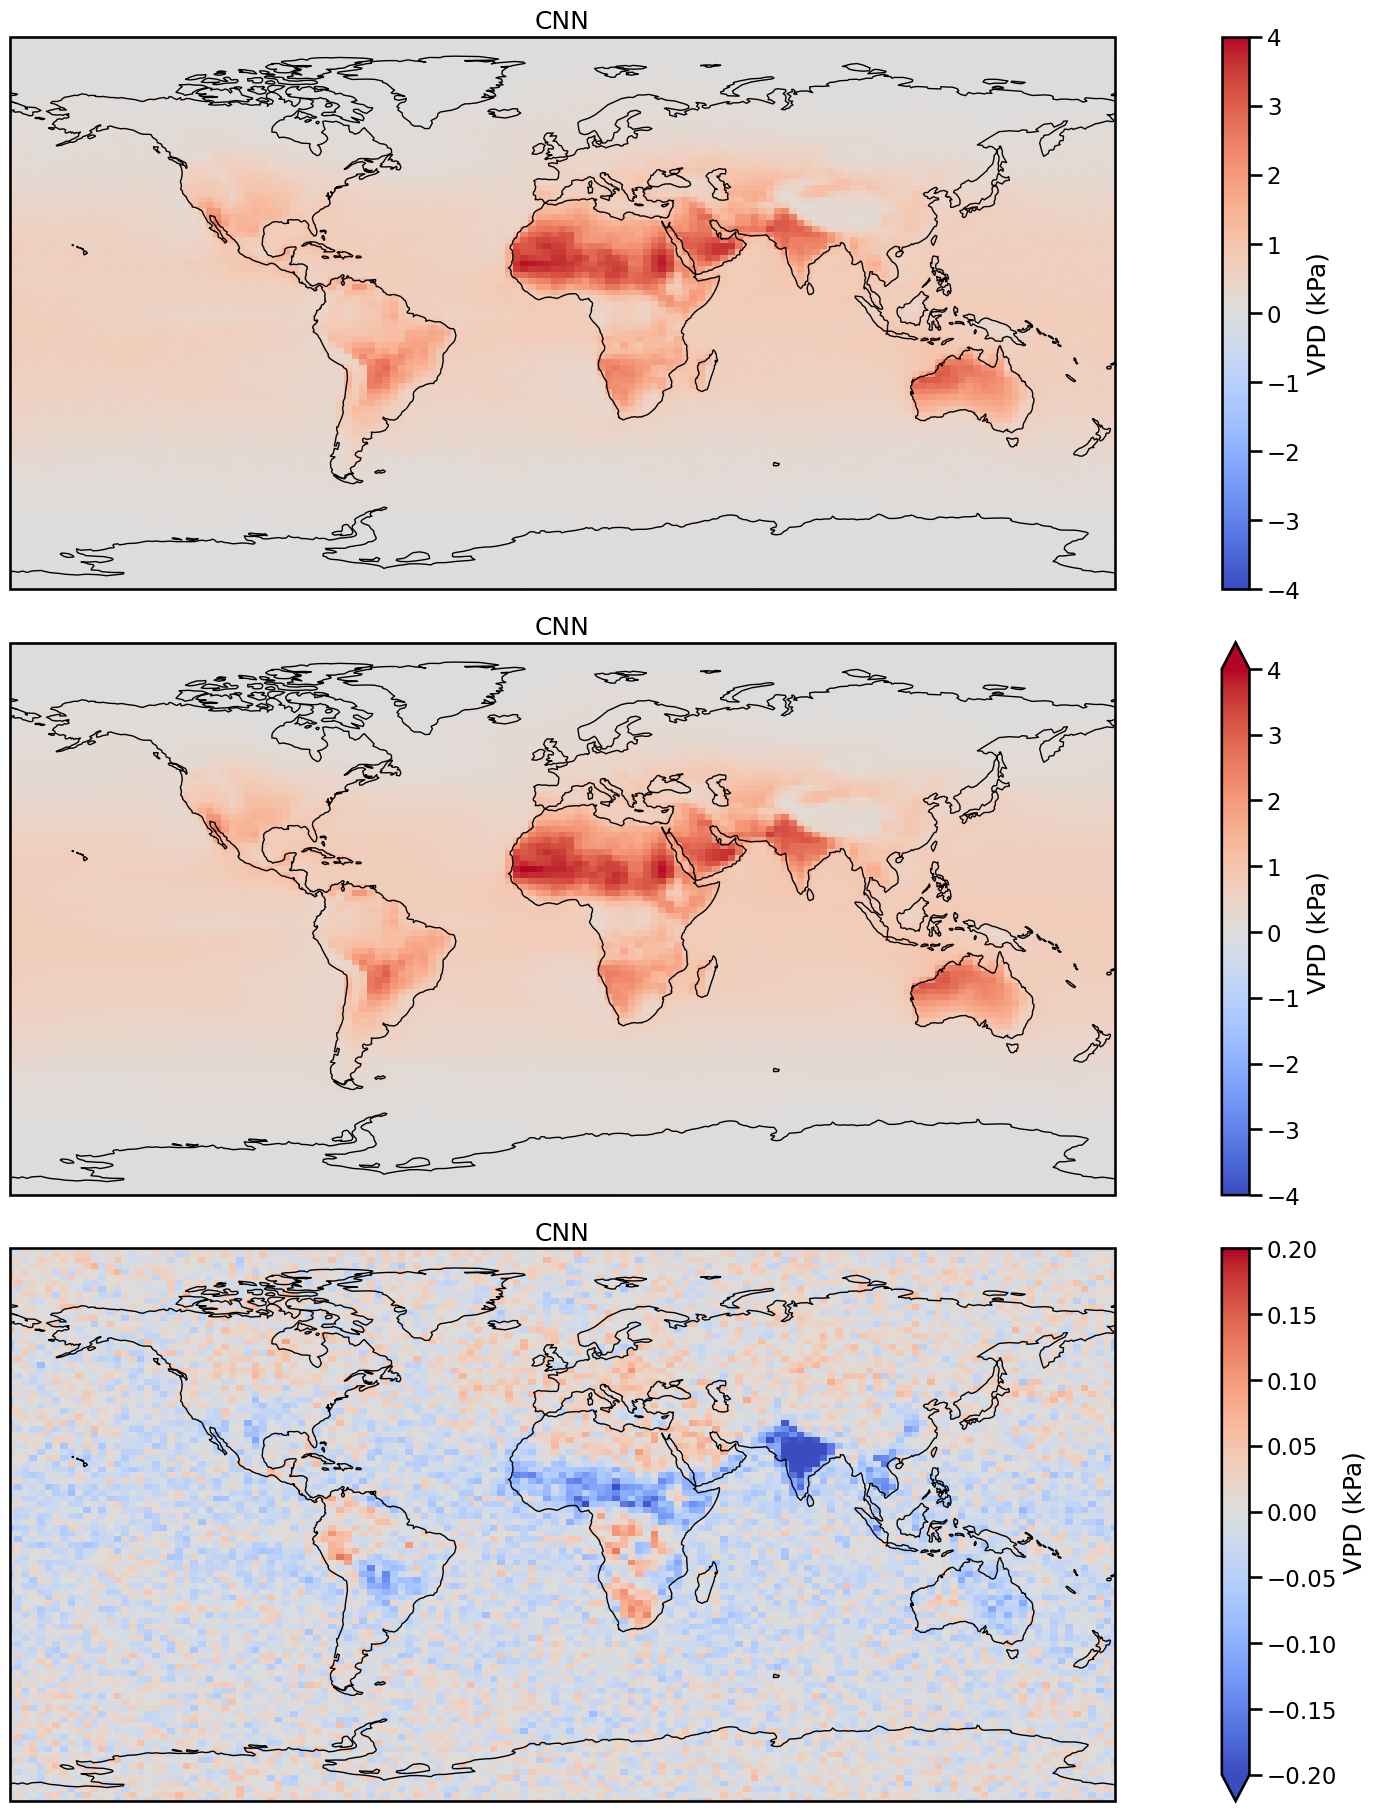

In [83]:
with sns.plotting_context("talk"):
    fig, axes = plt.subplots(3, 1, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    diff = predictions - Y_test
    plot_data = [predictions, Y_test, diff]
    for i in range(3):
        ax = axes[i]
        data = plot_data[i]['vpd'][-21:]
        kws = kwargs[i]
        title = "CNN"
        
        ax.set_title(title)
        mean_time = data.mean('time')
        # only show regions with statistically significant difference
        # when plotting differences
        
        
        (mean_time.plot(
                     cmap="coolwarm", 
                     ax=ax, 
                     add_labels=False, 
                     transform=proj, 
                     cbar_kwargs={"label":"VPD (kPa)", "orientation":'vertical'},
                     **kws))
        ax.coastlines()# variables used in plotting

In [97]:
sd_lat = predictions.lat[65]
sd_lon = predictions.lon[47]
sd_lat.data, sd_lon.data

(array(33.15789474), array(117.5))

In [98]:
def get_sd_VPD(vpd_data):
    return vpd_data.loc[dict(lat=sd_lat,lon=sd_lon)].sel(time=slice(2080,2100))['vpd'].data

In [99]:
sd_pred = get_sd_VPD(predictions)
sd_actual = get_sd_VPD(Y_test)

In [100]:
years = list(range(2080,2101))

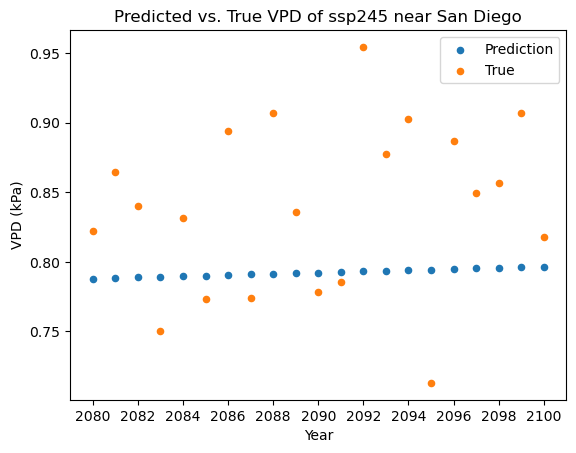

In [101]:
# create scatter plot
plt.scatter(years,sd_pred,s=20,label='Prediction')
plt.scatter(years,sd_actual,s=20,label='True')
plt.xticks(list(range(2080,2101,2)))
plt.xlabel('Year')
plt.ylabel('VPD (kPa)')
plt.title('Predicted vs. True VPD of ssp245 near San Diego')
plt.legend();